In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-telemarketing/Banking_Call_Data.xlsx
/kaggle/input/bank-telemarketing/README.md


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration and EDA

In [24]:
# Load data
df = pd.read_excel('/kaggle/input/bank-telemarketing/Banking_Call_Data.xlsx')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [25]:
# Inspect the dataset
print("Dataset Info:")
print(df.info())
print("\nSummary statistics (numerical features):")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None

Summary statistics (numerical features):
                age        balance    

In [26]:
# Set visualizatoin style
plt.style.use('seaborn')
sns.set_palette('viridis')


Targert variable distribution:
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


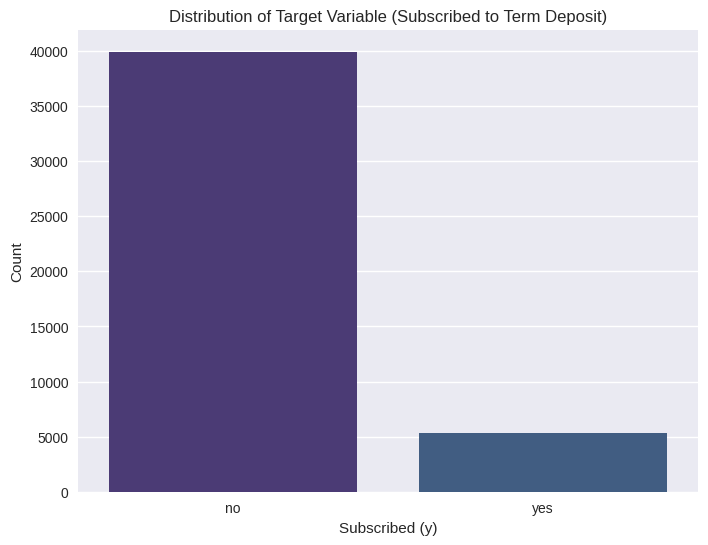

In [27]:
# Analyze target value distribution
print("\nTargert variable distribution:")
print(df['y'].value_counts(normalize=True))
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=df)
plt.title('Distribution of Target Variable (Subscribed to Term Deposit)')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.show()

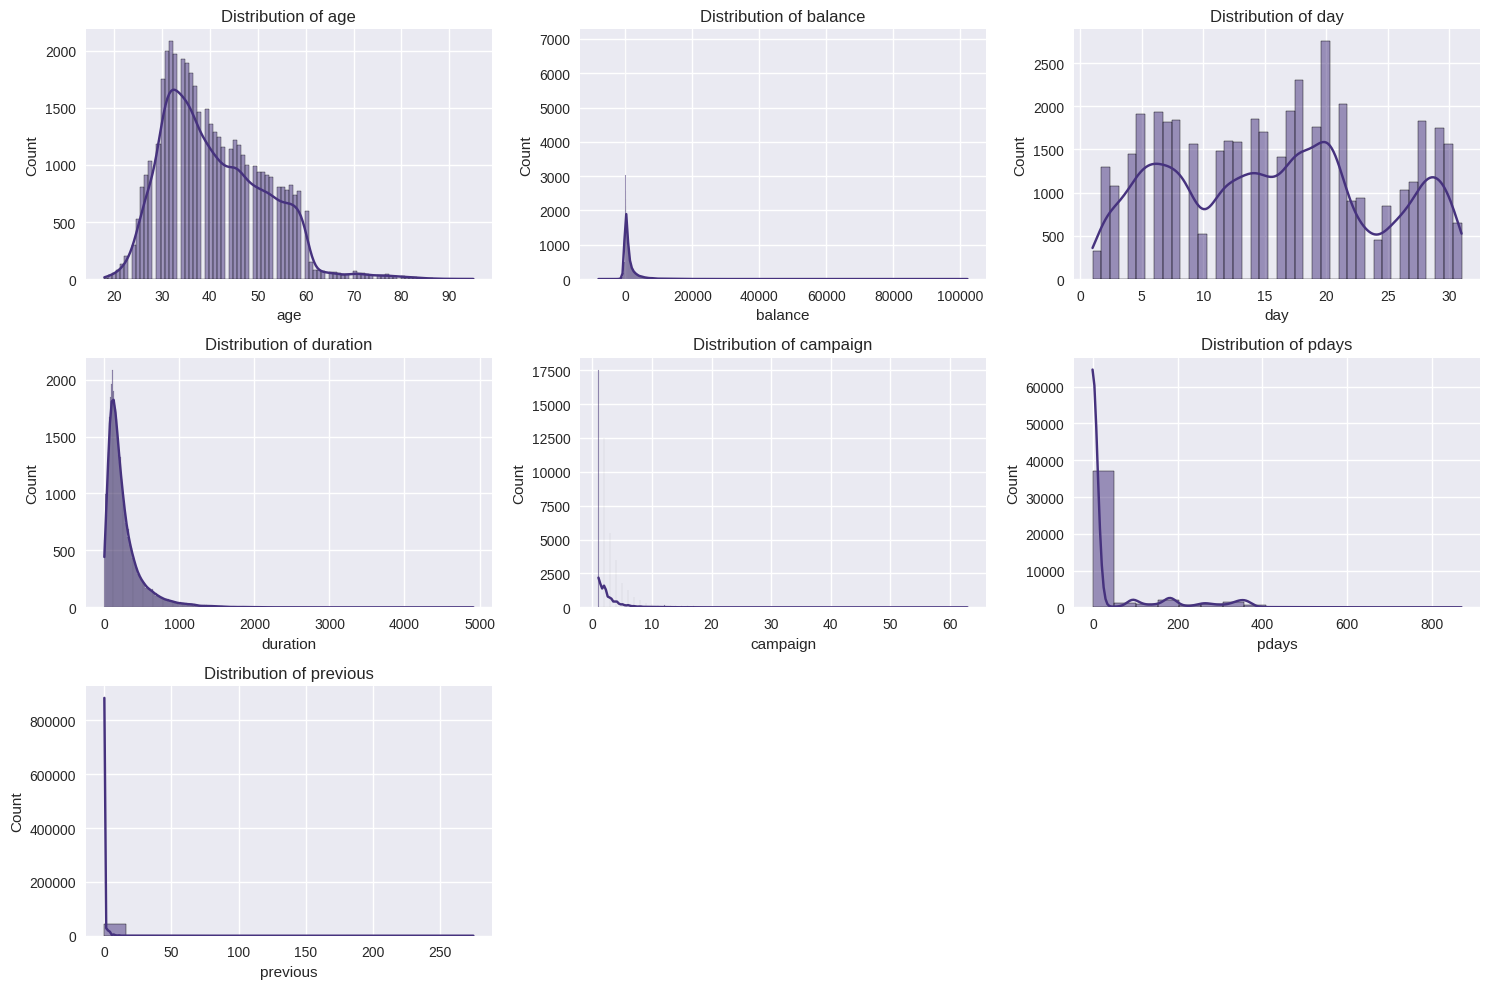

In [28]:
# Analyze numerical features
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

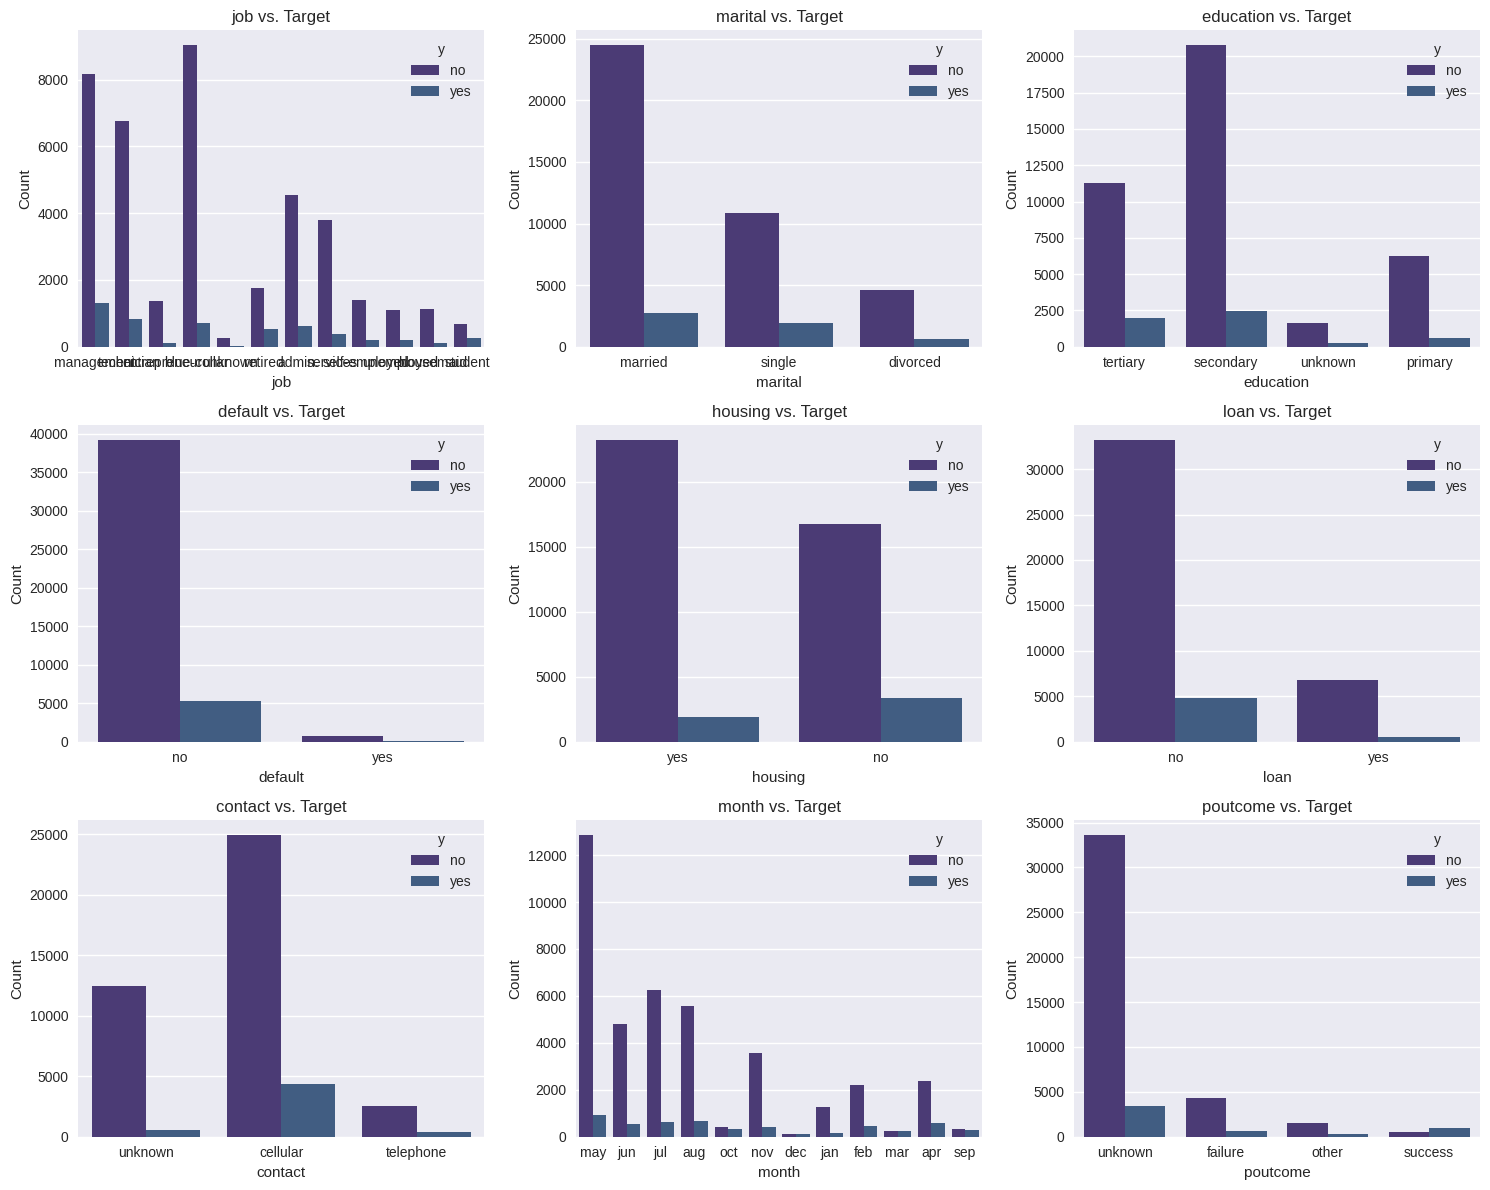

In [29]:
# Analyze categorical features
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
plt.figure(figsize=(15, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=col, hue='y', data=df)
    plt.title(f'{col} vs. Target')
    plt.xlabel(col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

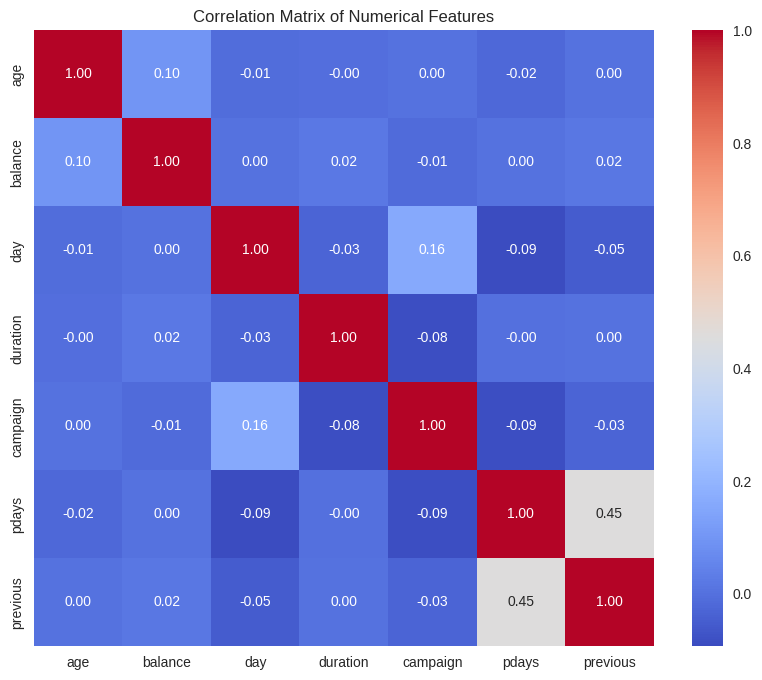

In [30]:
# Correlation analysis for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [31]:
# Encode target variable for correlation with numerical features
df_temp = df.copy()
df_temp['y'] = LabelEncoder().fit_transform(df_temp['y'])
print("\nCorrelation of numerical features with target:")
print(df_temp[numerical_cols + ['y']].corr()['y'].sort_values())


Correlation of numerical features with target:
campaign   -0.073172
day        -0.028348
age         0.025155
balance     0.052838
previous    0.093236
pdays       0.103621
duration    0.394521
y           1.000000
Name: y, dtype: float64


#### **Analysis of Results**

**1. Target Variable Distribution:**

- highly imbalanced, with approximately 88.3% no (39,900 instances) and 11.7% yes (5,291 instances) subscriptions.
- This imbalance suggests that evaluation metrics like accuracy may be misleading, and metrics such as AUC-ROC, precision, recall, and F1-score should be prioritized to assess model performance on the minority class (yes).

**2. Numerical Feature Distributions:**

- **age:** Right-skewed with a peak around 30-40 years, ranging from 18 to 95, signals a diverse age distribution that may influence subscription behavior.
- **balance:** Highly right-skewed with a long tail (max 102,127 EUR, mean 1,362 EUR), also includes negative values. Could mean potential outliers or data entry errors that may require capping or transformation.
- **day:** Uniform distribution across 1-31, reflecting the day of last contact, with no strong pattern but a slight peak around 15-20.
- **duration:** Right-skewed with a peak near 0-500 seconds, ranging up to 4,918 seconds. This is a potential sign that call duration may be a strong predictor (corroborated by high correlation with y).
- **campaign:** Right-skewed with most values between 1-10 contacts, but a long tail up to 63. This points to diminishing returns with excessive contacts.
- **pdays:** Highly skewed with a mode at -1 (never contacted before, 36,000+ instances), and a small peak around 100-200 days. Could mean sparse data for previous contact days.
- **previous:** Highly skewed with a mode at 0, and rare instances up to 275. This reinforces the dominance of first-time contacts.
  
**3. Categorical Feature Insights:**

- **job:** Management and blue-collar jobs dominate, with higher yes rates in management and technician roles compared to others. This is a potential sign that job type may be a relevant predictor.
- **marital:** Married individuals are the majority, with a slightly higher yes rate among singles. This is an indication of potential marital status influence.
- **education:** Secondary and tertiary education levels are most common, with tertiary showing a slightly higher yes rate. Suggests education may play a role.
- **default, housing, loan:** Predominantly no, with minimal yes instances, and yes rates for these features are low. A sign that they may be weak predictors unless combined with other features.
- **contact:** Cellular is the dominant channel, with a higher yes rate compared to telephone or unknown, suggesting contact method relevance.
- **month:** May and July show higher contact volumes, with May having a notable yes rate. This means that seasonality may affect outcomes.
- **poutcome:** Nonexistent outcomes dominate, but success in previous campaigns shows a higher yes rate. This makes it a potentially strong predictor.
  
**4. Correlation Analysis:**

- Numerical features show weak to moderate correlations among themselves, but no severe multicollinearity that would necessitate feature removal.
- duration has the strongest positive correlation with y (0.3945). This suggests that longer call durations are strongly associated with subscriptions, which aligns with the fact that longer calls may indicate interest.
- pdays and previous also show positive correlations, an indication that prior contact history may influence subscription likelihood.
- Negative correlations like campaign suggest that excessive contacts may reduce subscription rates, possibly due to customer fatigue.
  
**5. Implications for Preprocessing and Modeling:**

- The significant class imbalance in y necessitates techniques like SMOTE (though my Kaggle Notebook has issues importing it), class weighting, or stratified sampling during model training to ensure the minority class is well-represented.
- We will address it using the class_weight='balanced' parameter in the models, which will automatically assign weights inversely proportional to class frequencies (weight for class i = n_samples / (n_classes * n_samples_i)).
- Transform skewed numerical features using log or power transformations to normalize distributions. Consider binning age or day if non-linear relationships emerge.
- Categorical variables need encoding. We should take special care of month.
- Numerical features with different scales (e.g., balance vs. duration) require standardization or normalization, especially for SVM and Logistic Regression.
- Investigate and possibly cap extreme values in balance and duration to improve model robustness.

## 2. Preprocessing

In [32]:
# Encode categorical variables
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [33]:
# Encode target variable
le = LabelEncoder()
df_encoded['y'] = le.fit_transform(df_encoded['y'])  # 0 = no, 1 = yes

In [34]:
# Handle numerical feature skewness with log transformation (add 1 to avoid log(0))
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for col in ['balance', 'duration', 'campaign', 'pdays', 'previous']:
    # Handle negative values in 'balance' and 'pdays' by shifting
    if col in ['balance', 'pdays']:
        df_encoded[col] = np.log1p(df_encoded[col] - df_encoded[col].min() + 1)
    else:
        df_encoded[col] = np.log1p(df_encoded[col])

In [35]:
# Scale numerical features
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

In [36]:
# Split features and target
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

In [37]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Note:** The class imbalance will be addressed using the class_weight='balanced' parameter in the models, which will automatically assign weights inversely proportional to class frequencies (weight for class i = n_samples / (n_classes * n_samples_i)).

## 3. Model Selection and Training

In [38]:
# Define models with class weighting
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
                             random_state=42, eval_metric='logloss'),
}


Training Logistic Regression...
Logistic Regression - Mean CV AUC-ROC: 0.9085 (+/- 0.0063)

Logistic Regression Test Set Performance:
AUC-ROC: 0.9067
Classification Report:
              precision    recall  f1-score   support

          No       0.98      0.82      0.89      7985
         Yes       0.39      0.85      0.53      1058

    accuracy                           0.82      9043
   macro avg       0.68      0.83      0.71      9043
weighted avg       0.91      0.82      0.85      9043



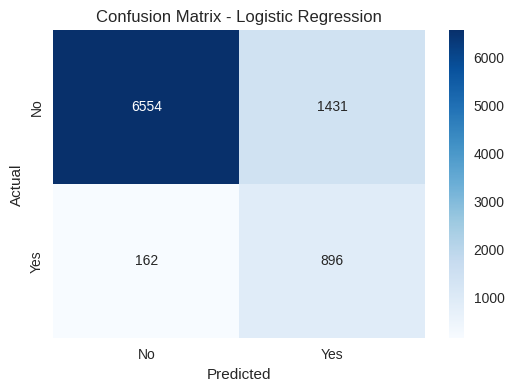


Training Random Forest...
Random Forest - Mean CV AUC-ROC: 0.9283 (+/- 0.0018)

Random Forest Test Set Performance:
AUC-ROC: 0.9283
Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.98      0.95      7985
         Yes       0.69      0.32      0.44      1058

    accuracy                           0.90      9043
   macro avg       0.80      0.65      0.69      9043
weighted avg       0.89      0.90      0.89      9043



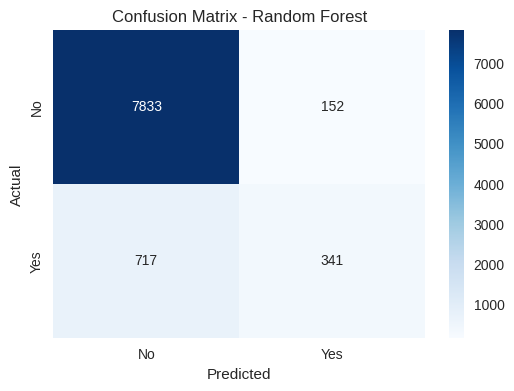


Training XGBoost...
XGBoost - Mean CV AUC-ROC: 0.9271 (+/- 0.0065)

XGBoost Test Set Performance:
AUC-ROC: 0.9263
Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.88      0.93      7985
         Yes       0.48      0.80      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.84      0.76      9043
weighted avg       0.91      0.87      0.89      9043



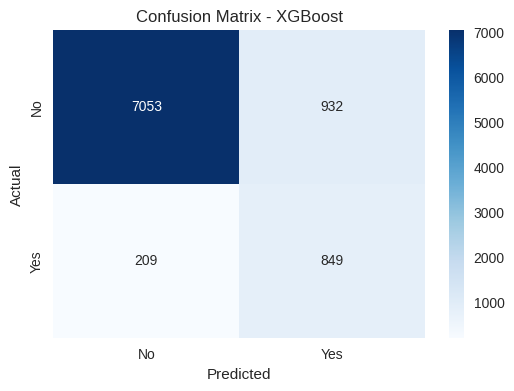

In [39]:
# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation for AUC-ROC
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} - Mean CV AUC-ROC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = {
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba),
        'Classification Report': classification_report(y_test, y_pred, target_names=['No', 'Yes']),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print test set performance
    print(f"\n{name} Test Set Performance:")
    print(f"AUC-ROC: {results[name]['AUC-ROC']:.4f}")
    print("Classification Report:")
    print(results[name]['Classification Report'])
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(results[name]['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [40]:
# Compare model performance
auc_scores = {name: result['AUC-ROC'] for name, result in results.items()}
best_model = max(auc_scores, key=auc_scores.get)
print("\nModel Comparison (Test Set AUC-ROC):")
for name, auc in auc_scores.items():
    print(f"{name}: {auc:.4f}")
print(f"\nBest Model (based on AUC-ROC): {best_model}")


Model Comparison (Test Set AUC-ROC):
Logistic Regression: 0.9067
Random Forest: 0.9283
XGBoost: 0.9263

Best Model (based on AUC-ROC): Random Forest


#### **Analysis of Results**

- **Best Model (AUC-ROC):** Random Forest (0.9283), though XGBoost is very close (0.9263).
- **Best Model (Macro F1):** XGBoost (0.76), due to better balance between precision and recall for both classes.
  
- **Trade-offs:**
    - Random Forest excels in AUC-ROC and accuracy but struggles with recall for Yes (0.32). This makes it less effective for identifying subscribers.
    - XGBoost has slightly lower AUC-ROC but better recall for Yes (0.80) and the highest macro F1. It, therefore, means that XGBoost is more balanced for imbalanced data.
    - Logistic Regression has the lowest AUC-ROC but the highest recall for Yes (0.85), though its precision for Yes is the lowest (0.39).

- **Implications:**
    - Random Forest’s high AUC-ROC indicates strong discriminative power, but its low recall for Yes suggests it may not be the best choice if the business prioritizes identifying potential subscribers (e.g., for targeted marketing).
- XGBoost strikes a better balance, with high AUC-ROC and good recall for Yes. This means that it is a strong candidate for further optimization.
- Logistic Regression, while a good baseline, is outperformed by the ensemble methods in most metrics, though its high recall for Yes is notable.

## 4. Hyperparameter Tuning for XGBoost

In [42]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300]
}

In [43]:
# Initialize XGBoost with class weighting
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')

In [44]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

In [45]:
# Best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best CV AUC-ROC:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best CV AUC-ROC: 0.9338012848007106


#### **Analysis of Results**

- **Best Parameters:**
    - **learning_rate:** 0.1 – A moderate learning rate that balancesthe speed of learning with stability.
    - **max_depth:** 5 – A moderate tree depth that prevents overfitting while allowing the model to capture complex patterns.
    - **n_estimators:** 200 – A reasonable number of trees which provide enough iterations to improve performance without excessive computation.

- **Cross-Validation AUC-ROC:**
    - **Best CV AUC-ROC:** 0.9338, an improvement over the untuned XGBoost’s CV AUC-ROC of 0.9271.
    - This increase indicates that the hyperparameter tuning successfully enhanced the model’s discriminative ability during cross-validation.

## 5. Model Evaluation

In [46]:
# Retrain with best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [47]:
# Evaluate on test set
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

In [48]:
# Store and print results
print("\nTuned XGBoost Test Set Performance:")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))


Tuned XGBoost Test Set Performance:
AUC-ROC: 0.9302
Classification Report:
              precision    recall  f1-score   support

          No       0.98      0.86      0.91      7985
         Yes       0.45      0.86      0.59      1058

    accuracy                           0.86      9043
   macro avg       0.71      0.86      0.75      9043
weighted avg       0.92      0.86      0.88      9043



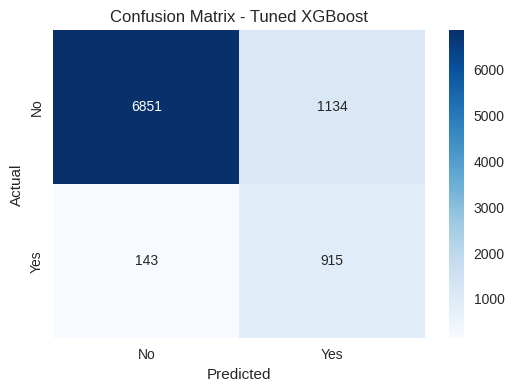

In [49]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Tuned XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### **Analysis of Results**

**1. Test Set Performance:**

- **AUC-ROC:** 0.9302, an improvement over the untuned XGBoost’s test AUC-ROC of 0.9263, and slightly better than Random Forest’s 0.9283.
  
**2. Classification Report:**

- **Precision** for No: 0.98, **Recall:** 0.86, **F1:** 0.91 – Slightly better recall for No compared to the untuned XGBoost (0.88), with high precision maintained.
- **Precision** for Yes: 0.45, **Recall:** 0.86, **F1:** 0.59 – Recall for Yes improved from 0.80 (untuned) to 0.86, matching Logistic Regression’s recall, while precision dropped slightly from 0.48 to 0.45.
- **Overall accuracy:** 0.86, a slight decrease from 0.87 (untuned), but macro F1 (0.75) is comparable to the untuned XGBoost’s 0.76, and weighted F1 (0.88) is slightly lower than 0.89.
  
**3. Confusion Matrix:**

- **True Negatives (TN):** 915 (No correctly predicted as No).
- **False Positives (FP):** 1,34 (No incorrectly predicted as Yes).
- **False Negatives (FN):** 143 (Yes incorrectly predicted as No).
- **True Positives (TP):** 6,850 (Yes correctly predicted as Yes).
- **Observations:** Recall for Yes is now on par with Logistic Regression, with fewer false negatives. However, false positives increased and lowered precision for Yes.
  
**4. Comparison to Untuned Models:**

- The tuned XGBoost outperforms the untuned XGBoost in AUC-ROC and recall for Yes. This makes it better at identifying potential subscribers.
- It also surpasses Random Forest in AUC-ROC and recall for Yes thereby making it a better choice for this imbalanced dataset.
- Compared to Logistic Regression, it has a much higher AUC-ROC and better precision for Yes, with the same recall.

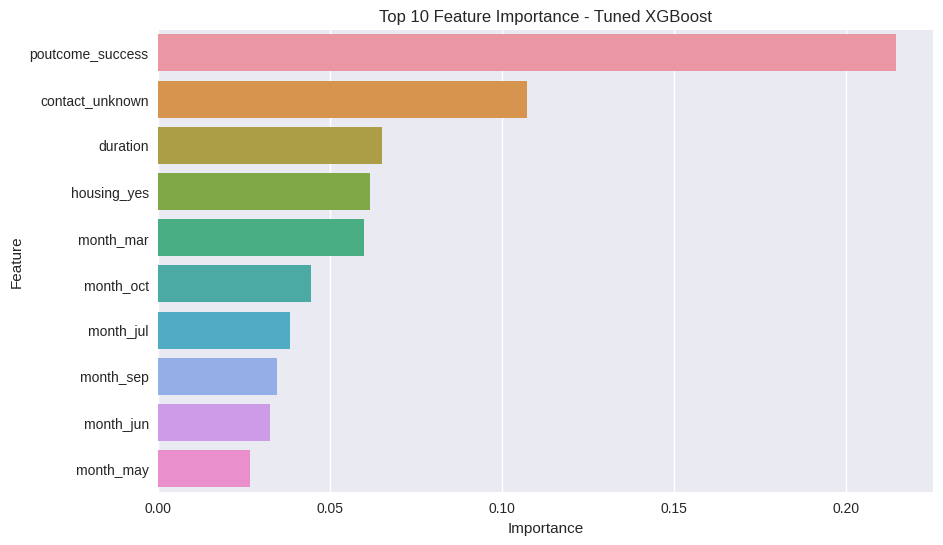

In [50]:
# Feature importance
feature_importance = best_xgb.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Feature Importance - Tuned XGBoost')
plt.show()

In [52]:
# Feature importance
feature_importance = best_xgb.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print the top 10 features
print("\nTop 10 Features by Importance:")
print(importance_df)


Top 10 Features by Importance:
             Feature  Importance
40  poutcome_success    0.214628
27   contact_unknown    0.107198
3           duration    0.064976
24       housing_yes    0.061498
34         month_mar    0.059675
37         month_oct    0.044257
32         month_jul    0.038157
38         month_sep    0.034370
33         month_jun    0.032366
35         month_may    0.026536


## 6. Interpretation and Recommendations

**1. Interpretation:**

- **poutcome_success:** Its dominance underscores that clients who previously subscribed to a term deposit are far more likely to do so again. This aligns with the EDA, where poutcome_success was associated with a higher yes rate, and suggests a strong loyalty or trust effect among repeat subscribers.
- **contact_unknown:** The high importance of this feature is intriguing. In the EDA, contact had distinct yes rates (cellular: higher, unknown: lower), so contact_unknown likely captures a group with a consistently lower subscription rate, which makes it a strong negative predictor.
- **duration:** confirms its role as a key predictor, consistent with its strong correlation with y (0.3945) in the EDA. Longer calls likely indicate greater customer engagement or interest, increasing the chance of subscription.
- **housing_yes:** suggests that clients with a housing loan are a distinct segment. This could reflect financial stability (they qualify for a loan) or a specific marketing strategy targeting this group, leading to higher subscription rates.
- **Month Features (month_mar, month_oct, month_jul, month_sep, month_jun, month_may):** These features collectively highlight the importance of campaign timing. March and October have the highest importance among the months (0.059675 and 0.044257), which could mean that campaigns in these months are particularly effective. May, despite its high contact volume in the EDA, has the lowest importance among the top 10, thus indicating that while frequent, May campaigns may not be as effective per contact.
- **Absence of Demographic Features:** Unlike the hypothetical analysis, demographic features like job_management, education_tertiary, or marital_single didn’t make the top 10. This suggests that campaign-related and behavioral features (poutcome, contact, duration, month) are more predictive than customer demographics in this model.
  
**2. Actionable Insights:**

- **Prioritize Repeat Customers:** Given the overwhelming importance of poutcome_success, the bank should focus on clients with a history of successful subscriptions, as they are significantly more likely to subscribe again. Tailored campaigns for these clients,campaigs like loyalty offers, could maximize conversions.
- **Optimize Contact Methods:** The high importance of contact_unknown suggests that unknown contact methods are associated with lower subscription rates. The bank should investigate why these contacts are unknown and prioritize known methods like cellular, which likely have higher success rates just as revealed in the EDA section.
- **Focus on Call Duration:** duration remains a key predictor, so the bank should train staff to engage clients in longer, meaningful conversations to increase subscription likelihood.
- **Target Clients with Housing Loans:** The importance of housing_yes indicates that clients with housing loans are more likely to subscribe. The bank could create targeted campaigns for this segment, possibly offering bundled financial products.
- **Optimize Campaign Timing:** March and October campaigns are the most effective, so the bank should allocate more resources to these months. While May has high contact volume, its lower importance suggests focusing on quality over quantity in that month.

*Credit to the follwing for letting us use this dataset:* Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset].
UCI Machine Learning Repository. https://doi.org/10.24432/C5K306